In [1]:
"""
Two-Body System Analysis
Investigating the central mass in Omega Centauri
Comparing acceleration vs
"""

'\nTwo-Body System Analysis\nInvestigating the central mass in Omega Centauri\nComparing acceleration vs\n'

In [2]:
from __future__ import print_function, division
import numpy as np
import matplotlib.pylab as plt
from PyAstronomy import pyasl
import two_body_utils as utils
import astropy.units as u
import astropy.constants as const
import pandas as pd
import matplotlib.lines as mlines
from astropy.table import Table
from datetime import datetime

In [3]:
"""
Binary Orbit Calculations for Sample Stars with a Distribution of Eccentricities
"""

# ========================================================
# 1. Sample Eccentricities from Thermal Distribution
# ========================================================

# Generate 100 eccentricities from thermal distribution f(e) = 2e
# Use inverse transform sampling with F(e) = e² → e = sqrt(U), where U ~ Uniform[0,1]
p = np.random.uniform(0, 1, utils.n_int)
ecc_distribution = np.sqrt(p)

# ========================================================
# 2. Orbital Period and Time Array
# ========================================================

# Get sample orbital period (in seconds) using circular orbit approximation
per_sample = utils.circular_period(semi_major=utils.semi_major_sample, speed=utils.v_xyz_sample)

# Create array of time values over one orbital period
# Time is in seconds if tau = 0 and period is in seconds
t = np.linspace(utils.tau, per_sample.value, utils.n_int)

# ========================================================
# 3. Initialize Arrays for Position and Velocity (3D)
# ========================================================

# Arrays to store position and velocity vectors for both bodies
r1 = np.zeros((len(ecc_distribution), len(t), 3))
r2 = np.zeros((len(ecc_distribution), len(t), 3))
v1 = np.zeros((len(ecc_distribution), len(t), 3))
v2 = np.zeros((len(ecc_distribution), len(t), 3))

# ========================================================
# 4. Loop: Compute Orbital Dynamics with BinaryOrbit
# ========================================================

for k, e_val in enumerate(ecc_distribution):
    # Initialize binary orbit with sampled eccentricity
    bo = pyasl.BinaryOrbit(
        m2m1 = utils.m2m1,               # Mass ratio (m2/m1)
        mtot = utils.mtot,               # Total mass (M_sun)
        per = per_sample.value / 86400,  # Period in days
        e = e_val,                       # Sampled eccentricity
        tau = utils.tau,                 # Time of periastron (d)
        Omega = utils.Omega,             # Ascending node longitude (deg)
        w = utils.w,                     # Argument of periapsis (deg)
        i = utils.i                      # Inclination (deg)
    )

    # Compute positions and velocities at each timestep
    for j, time in enumerate(t):
        r1[k, j], r2[k, j] = bo.xyzPos(time)     # Position vectors
        v1[k, j], v2[k, j] = bo.xyzVel(time)     # Velocity vectors

# ========================================================
# 5. Calculate Derived Quantities: Velocity & Distance
# ========================================================

# Velocity magnitude in XY-plane (m/s)
v1_xy = np.linalg.norm(v1[:, :, :2], axis=2)
v2_xy = np.linalg.norm(v2[:, :, :2], axis=2)

# Relative distance between the two masses (m)
rd = np.sqrt(np.sum((r1 - r2) ** 2, axis=2))

# Acceleration of the secondary in the XY-plane (km/s²)
a_xy_secondary = utils.xy_orbital_acceleration_secondary(rd=rd) / 1e3  # convert m/s² to km/s²

# ========================================================
# 6. Create Data Summary Table
# ========================================================

# Convert time to days
time_days = t / 86400

# Create 2D index grids for flattening
ecc_idxs, time_idxs = np.meshgrid(np.arange(rd.shape[0]), np.arange(rd.shape[1]), indexing='ij')

# Flatten all arrays for table construction
a_xy_secondary_vals = a_xy_secondary.flatten()
ecc_vals = ecc_distribution[ecc_idxs.flatten()]
time_vals = time_days[time_idxs.flatten()]
rd_vals = rd.flatten()

# Assemble the results into a DataFrame
summary_table = pd.DataFrame({
    "Eccentricity": ecc_vals,
    "Timestep (days)": time_vals,
    "Relative Distance (km)": rd_vals / 1000,  # Convert from meters
    "Acceleration of Secondary Body (km/s^2)": a_xy_secondary_vals
})

# Summary table of accelerations
summary_table


,Eccentricity,Timestep (days),Relative Distance (km),Acceleration of Secondary Body (km/s^2)
0,0.506584,0.000000,1.291984e+11,6.519456e-11
1,0.506584,32818.510207,2.092654e+11,2.485023e-11
2,0.506584,65637.020414,3.020802e+11,1.192562e-11
3,0.506584,98455.530621,3.620006e+11,8.304375e-12
4,0.506584,131274.040828,3.909253e+11,7.120951e-12
...,...,...,...,...
95,0.892330,164092.551035,4.915114e+11,4.504620e-12
96,0.892330,196911.061242,4.588678e+11,5.168332e-12
97,0.892330,229729.571449,3.888209e+11,7.198241e-12
98,0.892330,262548.081656,2.663997e+11,1.533409e-11


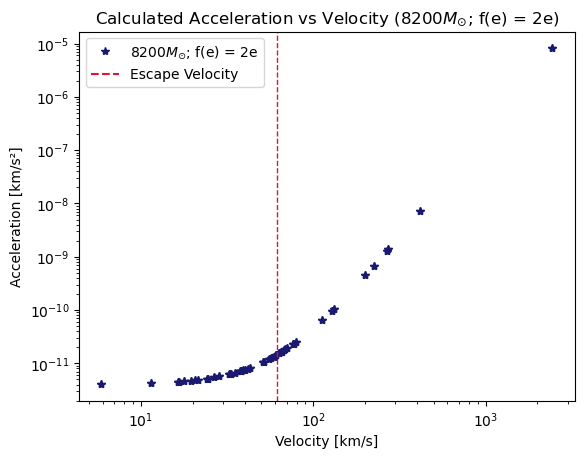

In [4]:
"""
Plots of Acceleration vs Time and Acceleration vs Velocity
for Calculated  Stars (8200; f(e) = 2e)
"""

# === Acceleration vs Time Plot ===
# Plot XY orbital acceleration [km/s²] vs time [days] for the secondary star
# plt.plot(t / 86400, a_xy_secondary, '*', color="midnightblue")
# plt.xlabel("Time [days]")
# plt.ylabel("XY Acceleration [km/s²]")
# plt.title("Sample Orbital Acceleration in XY")
# plt.axvline(utils.tau, ls=':', c='k', label="Time of Periastron")
# plt.legend()

# # Generate a timestamped filename
# sample_acc_title = "Sample_Orbital_Acceleration_wiht_Ecc_Distribution_"
# timestamp_acc = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
# filename_acc = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\Plots\{sample_acc_title}{timestamp_acc}.png"

# # Save and show the plot
# # plt.savefig(filename_acc)
# plt.show()

# === Acceleration vs Velocity Plot ===
# Plot XY orbital acceleration [km/s²] vs XY orbital velocity [km/s]
plt.plot(v2_xy / 1e3, a_xy_secondary, '*', color="midnightblue")  # Convert velocity from m/s to km/s

# Add vertical dashed line for escape velocity of the cluster
escape_velocity = 62  # km/s
plt.axvline(x=escape_velocity, color='crimson', linestyle='--', linewidth=1)

# Create custom legend handles
sample_star = mlines.Line2D([], [], color='midnightblue', marker='*', linestyle='None', label=r"8200$M_{\odot}$; f(e) = 2e")
escape_vel_line = mlines.Line2D([], [], color='crimson', linestyle='--', label='Escape Velocity')

# Get current plot legend handles and labels
handles, labels = plt.gca().get_legend_handles_labels()

# Append sample stars and escape velocity line
handles.extend([sample_star, escape_vel_line])
labels.extend([r"8200$M_{\odot}$; f(e) = 2e", 'Escape Velocity'])

# Add final legend with no title
plt.legend(handles=handles, labels=labels)

# Axis labels and plot title
plt.xlabel("Velocity [km/s]")
plt.ylabel("Acceleration [km/s²]")
plt.title(r"Calculated Acceleration vs Velocity (8200$M_{\odot}$; f(e) = 2e)")

# Use logarithmic scale for both axes
plt.xscale("log")
plt.yscale("log")

# Generate a timestamped filename
sample_acc_vel_title = "Calculated_Acceleration_vs_Velocity_8200_fe=2e_"
timestamp_acc_vel = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename_acc_vel = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\Plots\{sample_acc_vel_title}{timestamp_acc_vel}.png"

# Save and show the plot
#plt.savefig(filename_acc_vel)
plt.show()


In [5]:
"""
Observed 2D Velocities and Accelerations 
----------------------------------------
Observational data for 7 high-velocity stars in Omega Centauri
Calculations of plane-of-sky accelerations and propagation of uncertainties
"""

# ========================================================
# 1. Input: Measured Proper Motion Velocities (v2D)
# ========================================================

# 2D velocities in the plane of the sky [km/s]
# Sources A–G
v2D = np.array([113.0, 66.6, 94.9, 77.9, 69.6, 67.4, 66.2]) * u.km / u.s

# Corresponding 1σ uncertainties [km/s]
v2D_err = np.array([1.1, 4.1, 1.7, 2.0, 0.8, 0.4, 1.9]) * u.km / u.s

# ========================================================
# 2. Input: Angular Accelerations from Astrometry (RA/Dec)
# ========================================================

# Accelerations in Right Ascension [mas/yr²]
a_ra = np.array([-0.0069, 0.0702, 0.0028, 0.0357, 0.0072, 0.0052, -0.0197]) * u.mas / u.yr**2
a_ra_err = np.array([0.0083, 0.0239, 0.0333, 0.0177, 0.0042, 0.0038, 0.0267]) * u.mas / u.yr**2

# Accelerations in Declination [mas/yr²]
a_dec = np.array([0.0085, 0.0228, -0.0060, -0.0194, -0.0009, -0.0015, 0.0173]) * u.mas / u.yr**2
a_dec_err = np.array([0.0098, 0.0157, 0.0123, 0.0162, 0.0075, 0.0038, 0.0170]) * u.mas / u.yr**2

# ========================================================
# 3. Total Angular Acceleration and Uncertainty (Plane-of-Sky)
# ========================================================

# Total angular acceleration [mas/yr²]
a_total_masyr2 = np.sqrt(a_ra**2 + a_dec**2)

# Propagate uncertainty using partial derivatives
a_total_masyr2_err = np.sqrt(
    (a_ra * a_ra_err / a_total_masyr2)**2 +
    (a_dec * a_dec_err / a_total_masyr2)**2
)

# ========================================================
# 4. Conversion to Physical Acceleration [km/s²]
# ========================================================

# Convert angular acceleration to physical acceleration using cluster distance
a_total = utils.masyr2_to_kms2(a_masyr2=a_total_masyr2, distance_km=utils.distance_km)
a_total_err = utils.masyr2_to_kms2(a_masyr2=a_total_masyr2_err, distance_km=utils.distance_km)

# ========================================================
# 5. Create Summary Data Table
# ========================================================

# Build astropy table of all values
star_data = Table({
    "v2D": v2D,
    "v2D_err": v2D_err,
    "a_ra": a_ra,
    "a_ra_err": a_ra_err,
    "a_dec": a_dec,
    "a_dec_err": a_dec_err,
    "a_total": a_total,
    "a_total_err": a_total_err,
})

# Final table 
star_data


v2D,v2D_err,a_ra,a_ra_err,a_dec,a_dec_err,a_total,a_total_err
km / s,km / s,mas / yr2,mas / yr2,mas / yr2,mas / yr2,km / s2,km / s2
float64,float64,float64,float64,float64,float64,float64,float64
113.0,1.1,-0.0069,0.0083,0.0085,0.0098,8.930061383293236e-09,7.531455373299496e-09
66.6,4.1,0.0702,0.0239,0.0228,0.0157,6.02047938832453e-08,1.8958529783912896e-08
94.9,1.7,0.0028,0.0333,-0.006,0.0123,5.400731419743836e-09,1.4649029465648002e-08
77.9,2.0,0.0357,0.0177,-0.0194,0.0162,3.314142014778814e-08,1.4167818247443028e-08
69.6,0.8,0.0072,0.0042,-0.0009,0.0075,5.918566003817241e-09,3.483038561817065e-09
67.4,0.4,0.0052,0.0038,-0.0015,0.0038,4.4144539757184885e-09,3.0995661122692196e-09
66.2,1.9,-0.0197,0.0267,0.0173,0.017,2.1385320005943142e-08,1.8748565257835362e-08


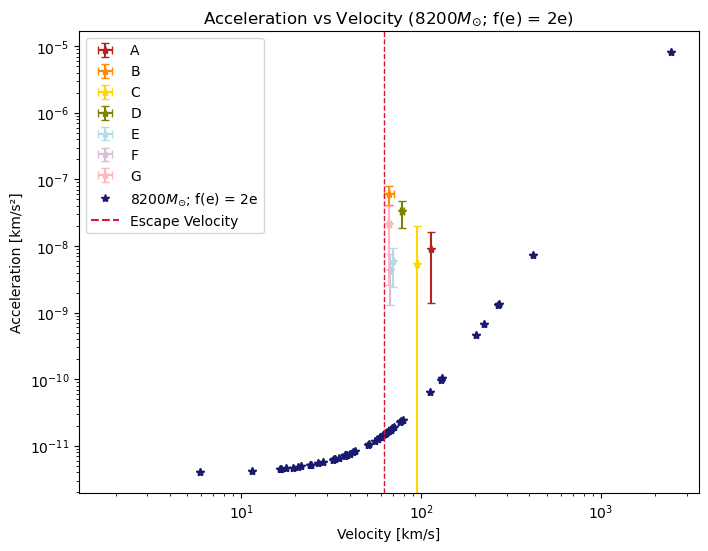

In [6]:
"""
Plot of Acceleration vs Velocities of Omega Centauri Stars and Calculated Stars (8200; f(e) = 2e)
"""

# Plot
plt.figure(figsize=(8, 6))
plt.xlabel("Velocity [km/s]")
plt.ylabel("Acceleration [km/s²]")
plt.title(r"Acceleration vs Velocity (8200$M_{\odot}$; f(e) = 2e)")
plt.xscale("log")
plt.yscale("log")

# ========== Plot Observed Stars with Error Bars ==========

# Colour and label settings for stars A–G
colours = ["firebrick", "darkorange", "gold", "olive", "powderblue", "thistle", "lightpink"]
labels = ["A", "B", "C", "D", "E", "F", "G"]

# Plot each star with error bars (1σ in velocity and acceleration)
for i in range(len(colours)):
    plt.errorbar(
        x=v2D[i].value,
        y=a_total[i].value,
        xerr=v2D_err[i].value,
        yerr=a_total_err[i].value,
        fmt="*",
        label=labels[i],
        color=colours[i],
        capsize=3
    )

# ========== Plot Simulated Binary Stars ==========

# Simulated secondary stars' velocities and accelerations
plt.plot(v2_xy / 1e3, a_xy_secondary, '*', color="midnightblue")  # Convert m/s to km/s

# ========== Plot Escape Velocity Threshold ==========

av_escape_velocity = 62  # km/s average escape velocity
plt.axvline(
    x=av_escape_velocity,
    color='crimson',
    linestyle='--',
    linewidth=1
)

# ========== Legend Handling ==========

# Custom handles for legend
sample_star = mlines.Line2D([], [], color='midnightblue', marker='*', linestyle='None', label=r"8200$M_{\odot}$; f(e) = 2e")
escape_vel_line = mlines.Line2D([], [], color='crimson', linestyle='--', label='Escape Velocity')

# Collect current legend entries (A–G)
handles, legend_labels = plt.gca().get_legend_handles_labels()

# Add custom entries
handles.extend([sample_star, escape_vel_line])
legend_labels.extend([r"8200$M_{\odot}$; f(e) = 2e", 'Escape Velocity'])

# Final legend
plt.legend(handles=handles, labels=legend_labels)

# ========== Save Plot ==========

# Create a timestamped filename for saving the plot
plot_name ="Acceleration_vs_Velocity_8200_fe=2e_"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
filename = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\Plots\{plot_name}_{timestamp}.png"

# Save and show the plot
#plt.savefig(filename)
plt.show()


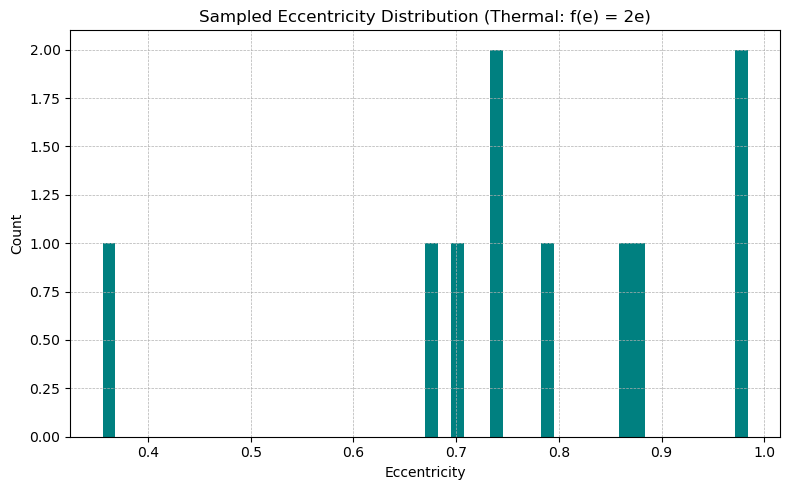

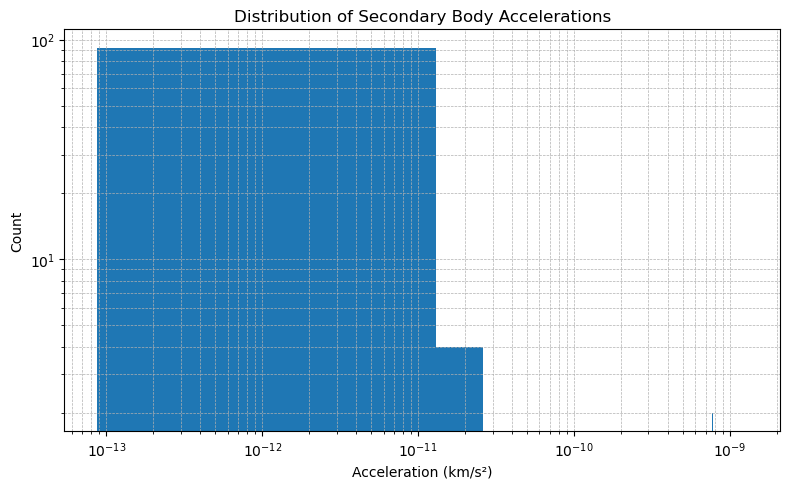

,Eccentricity,Timestep (days),Relative Distance (km),Acceleration of Secondary Body (km/s^2)
0,0.703441,0.000000e+00,5.335289e+11,3.823047e-12
1,0.703441,1.196783e+05,1.571658e+12,4.405642e-13
2,0.703441,2.393566e+05,2.357252e+12,1.958455e-13
3,0.703441,3.590349e+05,2.820335e+12,1.368119e-13
4,0.703441,4.787132e+05,3.037970e+12,1.179121e-13
...,...,...,...,...
95,0.878059,5.983915e+05,3.351396e+12,9.688892e-14
96,0.878059,7.180698e+05,3.127349e+12,1.112686e-13
97,0.878059,8.377481e+05,2.646726e+12,1.553486e-13
98,0.878059,9.574264e+05,1.807566e+12,3.330713e-13


In [7]:
"""
Binary Orbit Calculations with IMBH_av_plots from Mark Gieles
"""

# ========================================================
# 1. Sample Eccentricities from a Thermal Distribution
# ========================================================

# Thermal distribution: f(e) = 2e → F(e) = e^2 → e = sqrt(u) for u ∈ [0, 1]
p_Gieles = np.random.uniform(0, 1, utils.n_int)
ecc_distribution_Gieles = np.sqrt(p_Gieles)

# ========================================================
# 2. Define Orbital Period and Time Steps
# ========================================================

# Compute sample orbital period from circular velocity (returns value in seconds)
per_sample_Gieles = utils.circular_period(semi_major=utils.a_IMBH_av_plots, speed=utils.v_xyz_sample)

# Generate n_int time steps from periapsis (tau) to one full orbital period
t_Gieles = np.linspace(utils.tau, per_sample_Gieles.value, utils.n_int)  # seconds

# ========================================================
# 3. Initialize Arrays for Orbit Results
# ========================================================

# Shape: (n_eccentricities, n_timesteps, 3D xyz)
r1_Gieles = np.zeros((len(ecc_distribution_Gieles), len(t_Gieles), 3))  # Primary position
r2_Gieles = np.zeros_like(r1_Gieles)                                    # Secondary position
v1_Gieles = np.zeros_like(r1_Gieles)                                    # Primary velocity
v2_Gieles = np.zeros_like(r1_Gieles)                                    # Secondary velocity

# ========================================================
# 4. Compute Positions and Velocities for Each Eccentricity
# ========================================================

for k, e_val in enumerate(ecc_distribution_Gieles):
    # Setup orbit with IMBH + star (mass ratio = 1:200,000)
    bo_Gieles = pyasl.BinaryOrbit(
        m2m1 = 1/200000,                     # mass ratio
        mtot = 200000,                       # total mass in solar masses
        per = per_sample_Gieles.value / 86400,  # convert period to days
        e = e_val,
        tau = utils.tau,
        Omega = utils.Omega,
        w = utils.w,
        i = utils.i
    )

    for j, time in enumerate(t_Gieles):
        r1_Gieles[k, j], r2_Gieles[k, j] = bo_Gieles.xyzPos(time)
        v1_Gieles[k, j], v2_Gieles[k, j] = bo_Gieles.xyzVel(time)

# ========================================================
# 5. Compute Derived Quantities (Distance, Velocity, Acceleration)
# ========================================================

# Velocity magnitude in xy-plane [m/s]
v1_xy_Gieles = np.linalg.norm(v1_Gieles[:, :, :2], axis=2)
v2_xy_Gieles = np.linalg.norm(v2_Gieles[:, :, :2], axis=2)

# Relative distance between primary and secondary [m]
rd_Gieles = np.linalg.norm(r1_Gieles - r2_Gieles, axis=2)

# Acceleration of secondary body in xy-plane [km/s²]
a_xy_secondary_Gieles = utils.xy_orbital_acceleration_secondary(rd=rd_Gieles) / 1e3

# ========================================================
# 6. Summary Table for Output or Plotting
# ========================================================

# Convert seconds to days for output
time_days_Gieles = t_Gieles / 86400

# Create index meshgrid for flattening arrays
ecc_idxs_Gieles, time_idxs_Gieles = np.meshgrid(
    np.arange(rd_Gieles.shape[0]),
    np.arange(rd_Gieles.shape[1]),
    indexing='ij'
)

# Flatten for table construction
a_xy_secondary_vals_Gieles = a_xy_secondary_Gieles.flatten()
ecc_vals_Gieles = ecc_distribution_Gieles[ecc_idxs_Gieles.flatten()]
time_vals_Gieles = time_days_Gieles[time_idxs_Gieles.flatten()]
rd_vals_Gieles = rd_Gieles.flatten()

# Build DataFrame
summary_table_Gieles = pd.DataFrame({
    "Eccentricity": ecc_vals_Gieles,
    "Timestep (days)": time_vals_Gieles,
    "Relative Distance (km)": rd_vals_Gieles / 1000,  # Convert to km
    "Acceleration of Secondary Body (km/s^2)": a_xy_secondary_vals_Gieles
})

# ========================================================
# 7. Plotting Results
# ========================================================

# Histogram of Eccentricity Distribution 
plt.figure(figsize=(8, 5))
plt.hist(ecc_distribution_Gieles, bins=50, color='teal')
plt.xlabel("Eccentricity")
plt.ylabel("Count")
plt.title("Sampled Eccentricity Distribution (Thermal: f(e) = 2e)")
plt.grid(True, ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# Histogram of Acceleration Distribution 
plt.figure(figsize=(8, 5))
plt.hist(a_xy_secondary_vals_Gieles, bins=100, log=True)
plt.xlabel("Acceleration (km/s²)")
plt.ylabel("Count")
plt.xscale("log")
plt.title("Distribution of Secondary Body Accelerations")
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.tight_layout()
plt.show()

# Summary table of sample accelerations
summary_table_Gieles

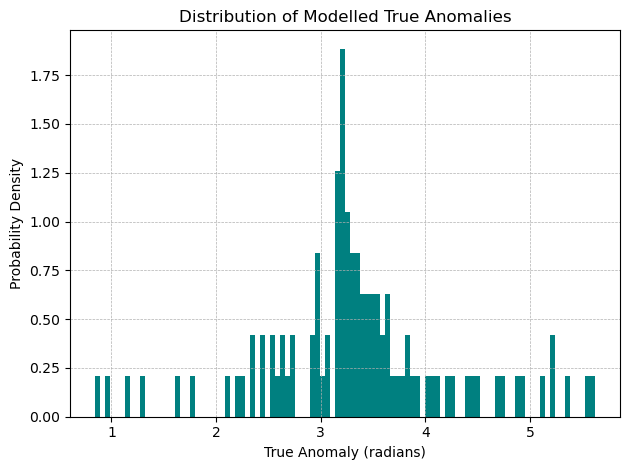

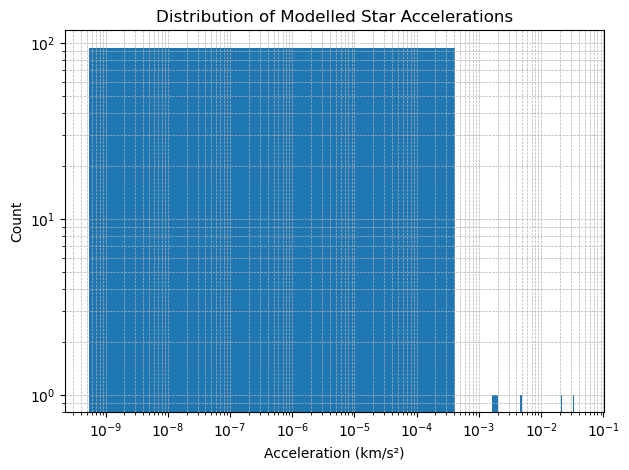

In [8]:
"""
Binary Orbit Calculations (8200; f(e) = 2e; nu)
"""

# ========================================================
# 1. Sample Eccentricities and Mean Anomalies
# ========================================================

# Sample eccentricities from the thermal distribution f(e) = 2e using inverse transform sampling:
# Let p ~ Uniform(0,1), then e = sqrt(p) ensures f(e) ∝ 2e
p = np.random.uniform(0, 1, utils.n_int)
eccentricities = np.sqrt(p)

# Sample mean anomalies (M) uniformly from [0, 2π]
# This reflects uniform motion in time along each orbit
# Non-unifrom distribution of true annomaly is calculated later
mean_anomaly = np.random.uniform(0, 2 * np.pi, utils.n_int)

# ========================================================
# 2. Compute Eccentric and True Anomalies
# ========================================================

# Initialize an array to store eccentric anomalies (E)
# Shape: (n_eccentricities, n_mean_anomalies)
ecc_anomaly = np.zeros((len(eccentricities), len(mean_anomaly)))

# Solve Kepler's equation: M = E - e*sin(E) → E, for each (e, M) pair
for k, e_val in enumerate(eccentricities):
    for j, m_anmly in enumerate(mean_anomaly):
        ecc_anomaly[k, j] = utils.eccentric_annomaly(M=m_anmly, e=e_val)

# Initialize an array to store true anomalies (ν)
true_anomaly = np.zeros_like(ecc_anomaly)

# Convert each eccentric anomaly and eccentricity to true anomaly 
for k, e_val in enumerate(eccentricities):
    for j in range(len(mean_anomaly)):
        E_val = ecc_anomaly[k, j]
        true_anomaly[k, j] = utils.true_anomaly(E=E_val, e=e_val)

# ========================================================
# 3. Compute Orbital Distances from Center of Mass
# ========================================================

# Compute instantaneous radial distance (r) from center of mass
# for the primary and secondary components in meters
a_primary = utils.com_radius(a=utils.semi_major_primary.to(u.m), e=eccentricities, nu=true_anomaly)     #m
a_secondary = utils.com_radius(a=utils.semi_major_sample.to(u.m),  e=eccentricities, nu=true_anomaly)    #m

# Compute the separation (r) in meters between the two bodies at each true anomaly
relative_distance = utils.relative_distance(
    a_primary=a_primary,
    a_secondary=a_secondary,
    nu=true_anomaly,
    e=eccentricities
)

# ========================================================
# 4. Compute XY-Plane Accelerations and Velocities with utils
# ========================================================

# The acceleration of the secondary body in the plane of the sky
# Units outputted: km/s² (but requires input distances in meters)
a_xy_nu = utils.xy_orbital_acceleration_secondary(rd=relative_distance).value

# The Orbital velocity of the secondary
# Units outputted: m/s² (requires input distances in meters)
# Then converted to km/s²
orbital_speed = utils.orbital_speed(a = a_secondary.to(u.m), e = eccentricities, nu=true_anomaly).to(u.km/u.s).value

# Convert to velocity in the plane of the sky
xy_orbital_speed= orbital_speed*np.cos(utils.i)


# ========================================================
# 5. Compute Orbital Velocity with BinaryOrbit
# ========================================================

# Get sample orbital period (in seconds) using a semi-major axis (km) and orbital speed approximation (km/s) from Omega Centauri stars
per_nu = utils.circular_period(semi_major=utils.semi_major_sample, speed=utils.v_xyz_sample).value

# Calculate timesteps from true anomalies
t_nu = utils.true_anomaly_to_time(nu = true_anomaly, e = eccentricities, a = utils.semi_major_sample.to(u.m))

# Convert timesteps to days and remove units to be compatible with BinaryOrbit
t_nu_days = t_nu.to_value(u.day)

# Initialize empty array for velocities of primary and secondary bodies in the binary orbit
v1_nu = np.zeros((len(eccentricities), len(t_nu_days), 3))
v2_nu = np.zeros((len(eccentricities), len(t_nu_days), 3))

for k, e_val in enumerate(eccentricities):
    # Initialize binary orbit with sampled eccentricity
    bo = pyasl.BinaryOrbit(
        m2m1 = utils.m2m1,               # Mass ratio (m2/m1)
        mtot = utils.mtot,               # Total mass (M_sun)
        per = per_nu / 86400,            # Period in days
        e = e_val,                       # Sampled eccentricity
        tau = utils.tau,                 # Time of periastron (d)
        Omega = utils.Omega,             # Ascending node longitude (deg)
        w = utils.w,                     # Argument of periapsis (deg)
        i = utils.i                      # Inclination (deg)
    )

    # Compute velocities at each timestep
    for j in range(len(t_nu_days[k])):
        time = t_nu_days[k, j]
        v1_nu[k, j], v2_nu[k, j] = bo.xyzVel(time)

# Velocity magnitude in XY-plane (m/s)
v1_xy_nu = np.linalg.norm(v1_nu[:, :, :2], axis=2)
v2_xy_nu = np.linalg.norm(v2_nu[:, :, :2], axis=2)

# ========================================================
# 5. Plot the Distributions
# ========================================================

# Plot histogram of true anomalies
plt.hist(true_anomaly.flatten(), bins=100, density=True, color='teal')
plt.xlabel('True Anomaly (radians)')
plt.ylabel('Probability Density')
plt.title('Distribution of Modelled True Anomalies')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot histogram of orbital accelerations
plt.hist(a_xy_nu.flatten(), bins=100, log=True)
plt.xscale("log")  # Logarithmic x-axis due to wide range of accelerations
plt.xlabel('Acceleration (km/s²)')
plt.ylabel('Count')
plt.title('Distribution of Modelled Star Accelerations')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

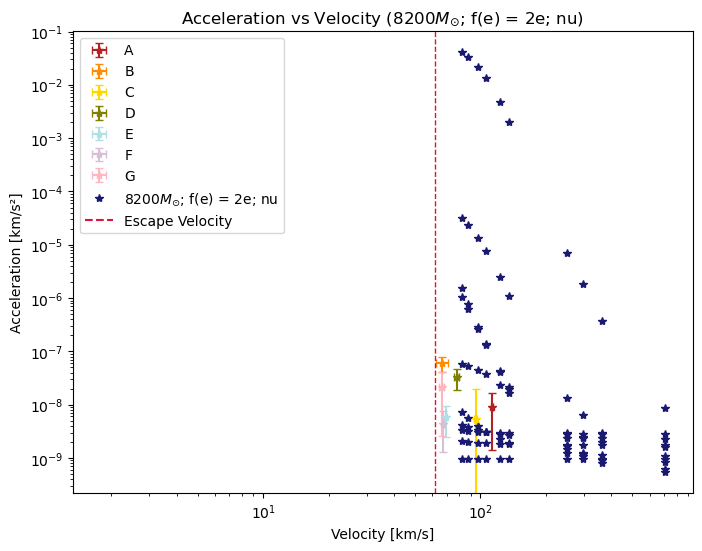

,Eccentricity,True Anomaly (rad),Timestep (days),Relative Distance (km),XY Acceleration (km/s²),XY Velocity (km/s),Note
66,0.983330,2.946671,47697.812443,3.564623e+11,8.564425e-09,703.110822,MAX Velocity
7,0.241563,5.224377,568297.539617,5.855291e+09,3.174158e-05,82.474603,MIN Velocity
6,0.241563,0.845745,133.194060,1.626550e+08,4.113302e-02,82.474604,MAX Acceleration
62,0.983330,3.212167,353751.751547,1.416342e+12,5.424869e-10,702.830899,MIN Acceleration
0,0.241563,3.680725,360814.326415,5.731288e+11,3.312997e-09,82.474604,
...,...,...,...,...,...,...,...
95,0.629481,2.718078,218656.345828,6.384515e+11,2.669744e-09,135.180746,
96,0.629481,1.798209,527.346357,7.329167e+08,2.025892e-03,135.180747,
97,0.629481,4.282988,561418.664151,3.166661e+10,1.085231e-06,135.180737,
98,0.629481,2.661062,166704.078681,7.563153e+11,1.902478e-09,135.180746,


In [26]:
"""
Plot of Acceleration vs Velocities of Omega Centauri Stars and Calculated Stars (8200; f(e) = 2e; nu)
"""

# Plot
plt.figure(figsize=(8, 6))
plt.xlabel("Velocity [km/s]")
plt.ylabel("Acceleration [km/s²]")
plt.title(r"Acceleration vs Velocity (8200$M_{\odot}$; f(e) = 2e; nu)")
plt.xscale("log")
plt.yscale("log")

# ========== Plot Observed Stars with Error Bars ==========

# Colour and label settings for stars A–G
colours = ["firebrick", "darkorange", "gold", "olive", "powderblue", "thistle", "lightpink"]
labels = ["A", "B", "C", "D", "E", "F", "G"]

# Plot each star with error bars (1σ in velocity and acceleration)
for i in range(len(colours)):
    plt.errorbar(
        x=v2D[i].value,
        y=a_total[i].value,
        xerr=v2D_err[i].value,
        yerr=a_total_err[i].value,
        fmt="*",
        label=labels[i],
        color=colours[i],
        capsize=3
    )

# ========== Plot Simulated Binary Stars ==========

# Simulated secondary stars' velocities and accelerations
plt.plot(v2_xy_nu / 1e3, a_xy_nu, '*', color="midnightblue")  # Convert m/s to km/s for velocity

# ========== Plot Escape Velocity Threshold ==========

av_escape_velocity = 62  # km/s average escape velocity
plt.axvline(
    x=av_escape_velocity,
    color='crimson',
    linestyle='--',
    linewidth=1
)

# ========== Legend Handling ==========

# Custom handles for legend
sample_star = mlines.Line2D([], [], color='midnightblue', marker='*', linestyle='None', label=r"8200$M_{\odot}$; f(e) = 2e; nu")
escape_vel_line = mlines.Line2D([], [], color='crimson', linestyle='--', label='Escape Velocity')

# Collect current legend entries (A–G)
handles, legend_labels = plt.gca().get_legend_handles_labels()

# Add custom entries
handles.extend([sample_star, escape_vel_line])
legend_labels.extend([r"8200$M_{\odot}$; f(e) = 2e; nu", 'Escape Velocity'])

# Final legend
plt.legend(handles=handles, labels=legend_labels)


# ========== Summary Table ========== 

# Create meshgrid indices to flatten arrays across both dimensions
ecc_idxs_nu, time_idxs_nu = np.meshgrid(
    np.arange(relative_distance.shape[0]),
    np.arange(relative_distance.shape[1]),
    indexing='ij'
)

# Flatten all arrays (ensure 1D) for table columns
summary_table_nu = pd.DataFrame({
    "Eccentricity": eccentricities[ecc_idxs_nu.ravel()],
    "True Anomaly (rad)": true_anomaly.ravel(),
    "Timestep (days)": t_nu_days.ravel(),
    "Relative Distance (km)": relative_distance.ravel() / 1000,  # convert m to km
    "XY Acceleration (km/s²)": a_xy_nu.ravel(),
    "XY Velocity (km/s)": v2_xy_nu.ravel() / 1e3  # convert m/s to km/s
})

# Identify max and min rows by velocity and acceleration
max_vel_row = summary_table_nu.loc[summary_table_nu["XY Velocity (km/s)"].idxmax()]
min_vel_row = summary_table_nu.loc[summary_table_nu["XY Velocity (km/s)"].idxmin()]
max_acc_row = summary_table_nu.loc[summary_table_nu["XY Acceleration (km/s²)"].idxmax()]
min_acc_row = summary_table_nu.loc[summary_table_nu["XY Acceleration (km/s²)"].idxmin()]

# Label each row
max_vel_row["Note"] = "MAX Velocity"
min_vel_row["Note"] = "MIN Velocity"
max_acc_row["Note"] = "MAX Acceleration"
min_acc_row["Note"] = "MIN Acceleration"

# Fill 'Note' column in the rest of the table with empty strings
summary_table_nu["Note"] = ""

# Combine new rows with original table
summary_table_nu = pd.concat([
    pd.DataFrame([max_vel_row, min_vel_row, max_acc_row, min_acc_row]),
    summary_table_nu
])

# ========== Save Plot ==========

# Create a timestamped filename for saving the plot
nu_plot_name ="Acceleration_vs_Velocity_8200_fe=2e_nu"
nu_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
nu_filename = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\Plots\{nu_plot_name}_{nu_timestamp}.png"

# Save and show the plot
#plt.savefig(nu_filename)
plt.show()
summary_table_nu

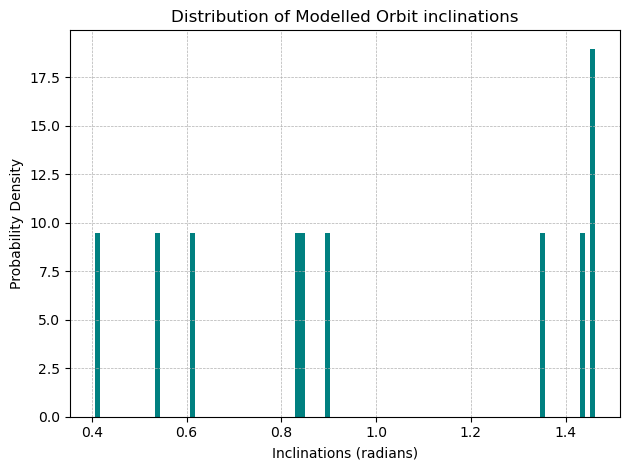

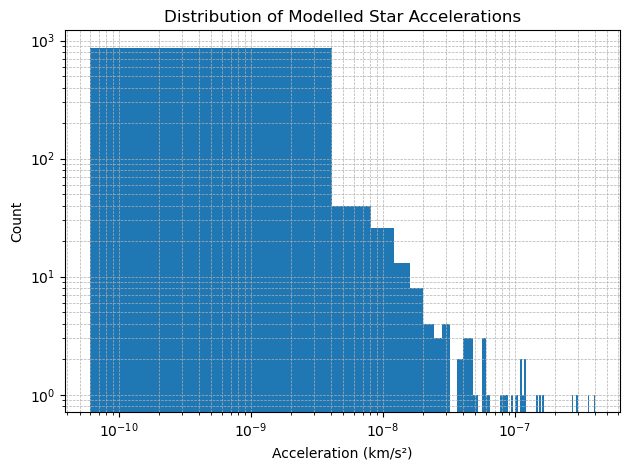

In [28]:
"""
Binary Orbit Calculations (8200; f(e) = 2e; nu; i = arccos(u))
"""

# ========================================================
# 1. Sample Eccentricities, Inclinations and Mean Anomalies
# ========================================================

# Sample eccentricities from the thermal distribution f(e) = 2e using inverse transform sampling:
# Let p ~ Uniform(0,1), then e = sqrt(p) ensures f(e) ∝ 2e
p_i = np.random.uniform(0, 1, utils.n_int)
eccentricities_i = np.sqrt(p_i)

# Sample mean anomalies (M) uniformly from [0, 2π]
# This reflects uniform motion in time along each orbit
# Non-unifrom distribution of true annomaly is calculated later
mean_anomaly_i = np.random.uniform(0, 2 * np.pi, utils.n_int)

# Sample inclinations by sampling uniform u=cos(i) and converting
u_inc = np.random.uniform(0, 1, utils.n_int)
inc_rad = np.arccos(u_inc)
inclinations_deg = np.degrees(inc_rad)

# ========================================================
# 2. Compute Eccentric and True Anomalies
# ========================================================

# Initialize an array to store eccentric anomalies (E)
ecc_anomaly_i = np.zeros((len(eccentricities_i), len(mean_anomaly_i)))

# Solve Kepler's equation: M = E - e*sin(E) → E, for each (e, M) pair
for k, e_val in enumerate(eccentricities_i):
    for j, m_anmly in enumerate(mean_anomaly_i):
        ecc_anomaly_i[k, j] = utils.eccentric_annomaly(M=m_anmly, e=e_val)
        
# Initialize an array to store true anomalies
true_anomaly_i = np.zeros_like(ecc_anomaly_i)

# Convert each eccentric anomaly and eccentricity to true anomaly 
for k, e_val in enumerate(eccentricities_i):
    for j in range(utils.n_int):
        E_val = ecc_anomaly_i[k, j]
        true_anomaly_i[k, j] = utils.true_anomaly(E=E_val, e=e_val)

# ========================================================
# 3. Compute Orbital Distances from Center of Mass
# ========================================================

# Compute instantaneous radial distance (r) from center of mass
# for the primary and secondary components in meters
a_primary_i = utils.com_radius(a=utils.semi_major_primary.to(u.m), e=eccentricities_i, nu=true_anomaly_i)     
a_secondary_i = utils.com_radius(a=utils.semi_major_sample.to(u.m),  e=eccentricities_i, nu=true_anomaly_i)    

# Compute the separation (r) in meters between the two bodies at each true anomaly
relative_distance_i = utils.relative_distance(
    a_primary=a_primary_i,
    a_secondary=a_secondary_i,
    nu=true_anomaly_i,
    e=eccentricities_i
)

# ========================================================
# 4. Compute XY-Plane Accelerations and Velocities with utils
# ========================================================

# The acceleration of the secondary body in the plane of the sky
# Units outputted: km/s² (but requires input distances in meters)
# a_xy_i = utils.xy_orbital_acceleration_secondary(rd=relative_distance_i, i = inc_rad).value
a_xy_i = np.zeros((len(relative_distance_i.flatten()), len(inc_rad)))  
for k, rd_i in enumerate(relative_distance_i.flatten()):
    for j, inc in enumerate(inc_rad):
        a_xy_i[k, j] = utils.xy_orbital_acceleration_secondary(rd=rd_i, i=inc).value

# The Orbital velocity of the secondary
# Units outputted: m/s² (requires input distances in meters)
# Then converted to km/s²
orbital_speed_i = utils.orbital_speed(a = a_secondary_i, e = eccentricities_i, nu=true_anomaly_i).to(u.km/u.s).value

# Convert to velocity in the plane of the sky
xy_orbital_speed_i = orbital_speed*np.cos(inc_rad)

# ========================================================
# 4. Compute Orbital Velocity with BinaryOrbit
# ========================================================

# Get sample orbital period (in seconds) using a semi-major axis (km) and orbital speed approximation (km/s) from Omega Centauri stars
per_i = utils.circular_period(semi_major=utils.semi_major_sample, speed=utils.v_xyz_sample).value

# Initialize and empty array for timesteps
t_i = np.zeros((len(eccentricities_i), len(mean_anomaly_i)))  

# Calculate timesteps from true anomalies and eccentricities
for k in range(len(eccentricities_i)):
    for j in range(len(mean_anomaly_i)):
        t_i[k, j] = utils.true_anomaly_to_time(
            nu=true_anomaly_i[k, j],
            e=eccentricities_i[k],
            a=utils.semi_major_sample.to(u.m)
        ).value

# Convert timesteps to days and remove units to be compatible with BinaryOrbit
t_i_days = t_i/ 86400

# Initialize empty array for velocities of primary (1) and secondary (2) bodies in the binary orbit
v1_i = np.zeros((len(eccentricities_i), len(inclinations_deg), len(t_i_days), 3))
v2_i = np.zeros((len(eccentricities_i), len(inclinations_deg), len(t_i_days), 3))

for k_e, e_val in enumerate(eccentricities_i):
    for k_i, i_val in enumerate(inclinations_deg):
        # Create BinaryOrbit instance for current e and i
        bo = pyasl.BinaryOrbit(
            m2m1 = utils.m2m1,               # Mass ratio (m2/m1)
            mtot = utils.mtot,               # Total mass (M_sun)
            per = per_nu / 86400,            # Period in days
            e = e_val,                       # Sampled eccentricity
            tau = utils.tau,                 # Time of periastron (d)
            Omega = utils.Omega,             # Ascending node longitude (deg)
            w = utils.w,                     # Argument of periapsis (deg)
            i=i_val
        )

        # Compute velocities at each timestep
        for j_nu in range(len(t_i_days[k])):
            time = t_i[k_e, j_nu]
            v1_i[k_e, k_i, j_nu, :], v2_i[k_e, k_i, j_nu, :] = bo.xyzVel(time)

# Velocity magnitude in XY-plane (m/s)
v1_xy_i = np.linalg.norm(v1_i[:, :, :, :2], axis=3)
v2_xy_i = np.linalg.norm(v2_i[:, :, :, :2], axis=3)

# ========================================================
# 5. Plot the Distributions
# ========================================================

# Plot histogram of inclinations in radians
plt.hist(inc_rad.flatten(), bins=100, density=True, color='teal')
plt.xlabel('Inclinations (radians)')
plt.ylabel('Probability Density')
plt.title('Distribution of Modelled Orbit inclinations')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Plot histogram of orbital accelerations
plt.hist(a_xy_i.flatten(), bins=100, log=True)
plt.xscale("log")  # Logarithmic x-axis due to wide range of accelerations
plt.xlabel('Acceleration (km/s²)')
plt.ylabel('Count')
plt.title('Distribution of Modelled Star Accelerations')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


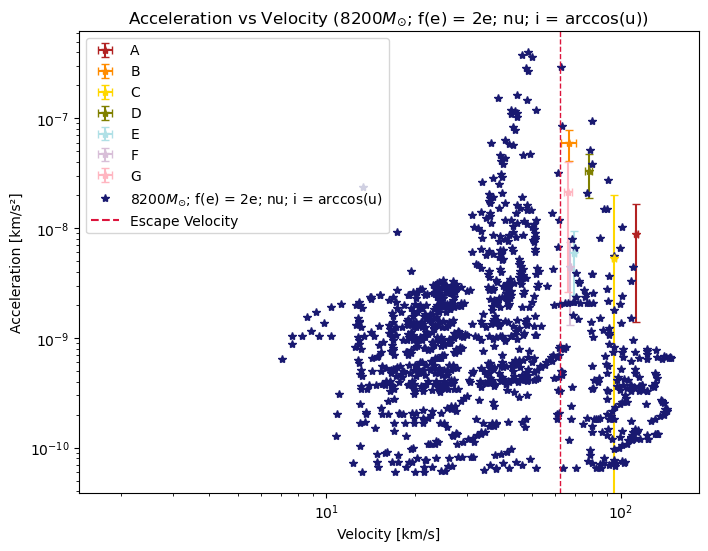

,Eccentricity,Inclination (deg),True Anomaly (rad),Timestep (days),Relative Distance (km),XY Acceleration (km/s²),XY Velocity (km/s),Label
0,0.223819,23.335349,4.068230,405373.467637,4.989480e+10,4.013776e-07,52.256865,Max Acceleration
1,0.918002,83.747816,3.160164,300934.517543,1.406828e+12,5.988121e-11,61.754735,Min Acceleration
2,0.816592,23.335349,3.171727,300934.517543,1.401850e+12,5.084645e-10,147.964430,Max Velocity
3,0.918002,83.747816,3.117164,264775.760620,1.336771e+12,6.632216e-11,7.033523,Min Velocity
4,0.863137,77.564888,3.166654,300934.517543,1.404322e+12,1.188241e-10,93.111463,
...,...,...,...,...,...,...,...,...
999,0.791068,83.747816,3.098375,264775.760620,1.329249e+12,6.707480e-11,9.837720,
1000,0.791068,83.747816,3.429303,409816.596054,5.941484e+11,3.357241e-10,21.073296,
1001,0.791068,83.747816,2.702782,114476.139434,7.738598e+11,1.979009e-10,21.074843,
1002,0.791068,83.747816,3.416985,405373.467637,7.390613e+11,2.169759e-10,20.788938,


In [32]:
"""
Plot of Acceleration vs Velocities of Omega Centauri Stars and Calculated Stars (8200; f(e) = 2e; nu: i = arccos(u))
"""

# Plot
plt.figure(figsize=(8, 6))
plt.xlabel("Velocity [km/s]")
plt.ylabel("Acceleration [km/s²]")
plt.title(r"Acceleration vs Velocity (8200$M_{\odot}$; f(e) = 2e; nu; i = arccos(u))")
plt.xscale("log")
plt.yscale("log")

# ========== Plot Observed Stars with Error Bars ==========

# Colour and label settings for stars A–G
colours = ["firebrick", "darkorange", "gold", "olive", "powderblue", "thistle", "lightpink"]
labels = ["A", "B", "C", "D", "E", "F", "G"]

# Plot each star with error bars (1σ in velocity and acceleration)
for i in range(len(colours)):
    plt.errorbar(
        x=v2D[i].value,
        y=a_total[i].value,
        xerr=v2D_err[i].value,
        yerr=a_total_err[i].value,
        fmt="*",
        label=labels[i],
        color=colours[i],
        capsize=3
    )

# ========== Plot Simulated Binary Stars ==========

# Simulated secondary stars' velocities and accelerations
plt.plot(v2_xy_i.flatten() / 1e3, a_xy_i.flatten(), '*', color="midnightblue")

# ========== Plot Escape Velocity Threshold ==========

av_escape_velocity = 62  # km/s average escape velocity
plt.axvline(
    x=av_escape_velocity,
    color='crimson',
    linestyle='--',
    linewidth=1
)

# ========== Legend Handling ==========

# Custom handles for legend
sample_star = mlines.Line2D([], [], color='midnightblue', marker='*', linestyle='None', label=r"8200$M_{\odot}$; f(e) = 2e; nu; i = arccos(u)")
escape_vel_line = mlines.Line2D([], [], color='crimson', linestyle='--', label='Escape Velocity')

# Collect current legend entries (A–G)
handles, legend_labels = plt.gca().get_legend_handles_labels()

# Add custom entries
handles.extend([sample_star, escape_vel_line])
legend_labels.extend([r"8200$M_{\odot}$; f(e) = 2e; nu; i = arccos(u)", 'Escape Velocity'])

# Final legend
plt.legend(handles=handles, labels=legend_labels)


# ========== Save Plot ==========

# Create a timestamped filename for saving the plot
i_plot_name ="Acceleration_vs_Velocity_8200_fe=2e_nu_i_"
i_timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
i_filename = rf"C:\Users\macke\OneDrive - Saint Marys University\Summer Research 2025\Plots\{i_plot_name}_{i_timestamp}.png"

# Save and show the plot
#plt.savefig(i_filename)
plt.show()

# ========== Summary Table ========== 

# Grid of indices
ecc_idxs, inc_idxs, time_idxs = np.meshgrid(
    np.arange(len(eccentricities_i)),
    np.arange(len(inc_rad)),
    np.arange(len(mean_anomaly_i)),
    indexing='ij'
)

# Flatten all arrays to build the table
ecc_flat = eccentricities_i[ecc_idxs.ravel()]
inc_flat = np.degrees(inc_rad)[inc_idxs.ravel()]
nu_flat = true_anomaly_i[ecc_idxs.ravel(), time_idxs.ravel()]
t_flat = t_i[ecc_idxs.ravel(), time_idxs.ravel()] / 86400
rd_flat = relative_distance_i[ecc_idxs.ravel(), time_idxs.ravel()] / 1000  # km
a_flat = a_xy_i[:, :len(inc_rad)].reshape(len(eccentricities_i), len(mean_anomaly_i), len(inc_rad)).transpose(0, 2, 1).ravel()
v_flat = v2_xy_i.ravel() / 1e3  # km/s

# table
summary_table_i = pd.DataFrame({
    "Eccentricity": ecc_flat,
    "Inclination (deg)": inc_flat,
    "True Anomaly (rad)": nu_flat,
    "Timestep (days)": t_flat,
    "Relative Distance (km)": rd_flat,
    "XY Acceleration (km/s²)": a_flat,
    "XY Velocity (km/s)": v_flat
})

# Get rows with max and min acceleration
max_acc_row = summary_table_i.loc[summary_table_i["XY Acceleration (km/s²)"].idxmax()]
min_acc_row = summary_table_i.loc[summary_table_i["XY Acceleration (km/s²)"].idxmin()]

# Get rows with max and min velocity
max_vel_row = summary_table_i.loc[summary_table_i["XY Velocity (km/s)"].idxmax()]
min_vel_row = summary_table_i.loc[summary_table_i["XY Velocity (km/s)"].idxmin()]

# Label the rows for clarity
max_acc_row["Label"] = "Max Acceleration"
min_acc_row["Label"] = "Min Acceleration"
max_vel_row["Label"] = "Max Velocity"
min_vel_row["Label"] = "Min Velocity"

# Fill the rest with empty strings to avoid NaNs
summary_table_i["Label"] = ""

# Create a new DataFrame for the labeled rows
top_rows = pd.DataFrame([max_acc_row, min_acc_row, max_vel_row, min_vel_row])

# Concatenate labeled top rows with the full table
summary_table_i = pd.concat([top_rows, summary_table_i], ignore_index=True)

# Display table
summary_table_i